# 7144COMP/CW2: Bird Multiple Object Detection Using Faster R-CNN ResNet101 Network 
## PART V: Deployment and Inference


In this notebook, I have frozen my trained model in the correct format for model inference. I deployed the saved model and made inferences on unseen data from the test subset and others downloaded from the Internet, using my trained model.

The results are discussed at the end of this notebook.

<img src="https://ayoubb.com/wp-content/uploads/2022/12/Screen-Recording-2022-12-24-at-9.38.43-PM.gif" />

*Figure: Deployment and inference on Roboflow Cloud* 

### Prerequisites
This notebook runs locally in the environment *tf-gpu*.
- Environment Setup (see Part 0)
- Preprocessing (see Part 1)
- Training (see Part 2)

## 1. Freeze our trained model's graph in a ```.pb``` format for model inferencing using ```exporter_main_v2.py``` script

- Graphs are data structures that contain a set of tf.Operation objects, which represent units of computation; and tf.Tensor objects, which represent the units of data that flow between operations. 

- Graphs are defined in a tf.Graph context. Since these graphs are data structures, they can be saved, run, and restored all without the original Python code.

Here we will save our OD inference graph files in  **fasterrcnn_inference_graph/saved_model** 

After freezing the TensorFlow graph for inference, TensorRT will optimize the TF sub-graphs. TensorRT then replaces each supported subgraph with a TensorRT optimized node, producing a frozen graph stored a **.pb file** that runs in TensorFlow for inference. The following flow chart illustrates the workflow (source: nVidia).
<img src="https://ayoubb.com/wp-content/uploads/2022/12/Flowchart-scaled.jpg" />

In [2]:
import os
import sys
import glob
import numpy as np
import tensorflow as tf

# Image manipulation
from PIL import Image 
from six import BytesIO

# Object detection libraries
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Check current conda environment
print(sys.executable)

/home/msc1/anaconda3/envs/tf_gpu/bin/python


In [27]:
# get the current dir
current_dir = os.getcwd()

# Object detection dir
object_detection_dir = os.path.join(current_dir, 'models/research/object_detection')

# Model training directory and config pipeline
model_dir = os.path.join(current_dir, 'training')

# pipleline
pipeline_config_path = os.path.join(current_dir, 'fasterrcnn_config.config')

# Labelmap
labelmap_path = os.path.join(current_dir, 'Birds', 'train', 'birds_label_map.pbtxt')
%cd $object_detection_dir

/home/msc1/Desktop/7144COMP/Models/faster_rcnn_resnet101/models/research/object_detection


In [28]:
# Output directory where out inference graph is saved
output_directory = 'fasterrcnn_inference_graph'

In [29]:
current_dir

'/home/msc1/Desktop/7144COMP/Models/faster_rcnn_resnet101'

In [30]:
# Freeze our model graph and save it in a .pb format  
!python $current_dir/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir $model_dir \
    --output_directory $output_directory \
    --pipeline_config_path $pipeline_config_path

W0109 15:48:04.147119 139803601659712 save.py:271] Found untraced functions such as FirstStageBoxPredictor_layer_call_fn, FirstStageBoxPredictor_layer_call_and_return_conditional_losses, mask_rcnn_keras_box_predictor_layer_call_fn, mask_rcnn_keras_box_predictor_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op while saving (showing 5 of 135). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: fasterrcnn_inference_graph/saved_model/assets
I0109 15:48:10.144740 139803601659712 builder_impl.py:797] Assets written to: fasterrcnn_inference_graph/saved_model/assets
INFO:tensorflow:Writing pipeline config file to fasterrcnn_inference_graph/pipeline.config
I0109 15:48:11.357811 139803601659712 config_util.py:253] Writing pipeline config file to fasterrcnn_inference_graph/pipeline.config


#### saved_model.pb file (fasterrcnn_inference_graph/saved_model.pb)
.pb stands for Protocol Buffers, it is a language-neutral, platform-neutral extensible mechanism for serializing structured data (Our TF Graph). It is widely used in model deployment, such as fast inference tool TensorRT.

## 2. Perform inference on our frozen model using unseen test images

In [31]:
# Convert images to a numpy array
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Run inference for a numpay image
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.7,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [32]:
# Load label map data (for plotting)
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)

In [34]:
# Resets all states generated by Keras.
tf.keras.backend.clear_session()

# Load our model
model = tf.saved_model.load(f'/{current_dir}/{output_directory}/saved_model')

In [35]:
current_dir

'/home/msc1/Desktop/7144COMP/Models/faster_rcnn_resnet101'

2023-01-09 15:50:57.464448: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 963379200 exceeds 10% of free system memory.
2023-01-09 15:50:57.608301: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 240844800 exceeds 10% of free system memory.


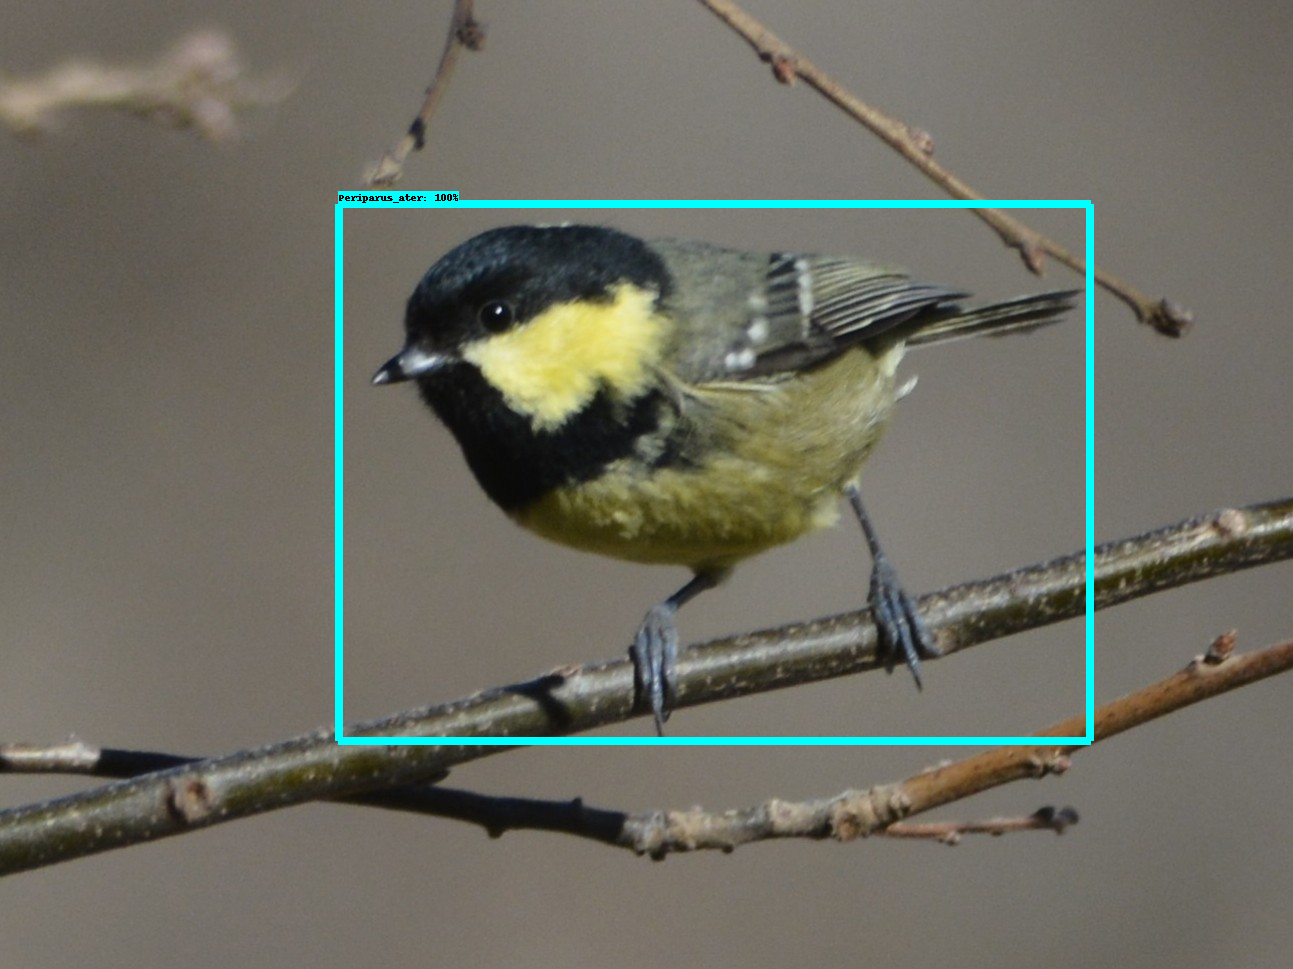

2023-01-09 15:50:59.420060: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 963379200 exceeds 10% of free system memory.
2023-01-09 15:50:59.537487: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 240844800 exceeds 10% of free system memory.


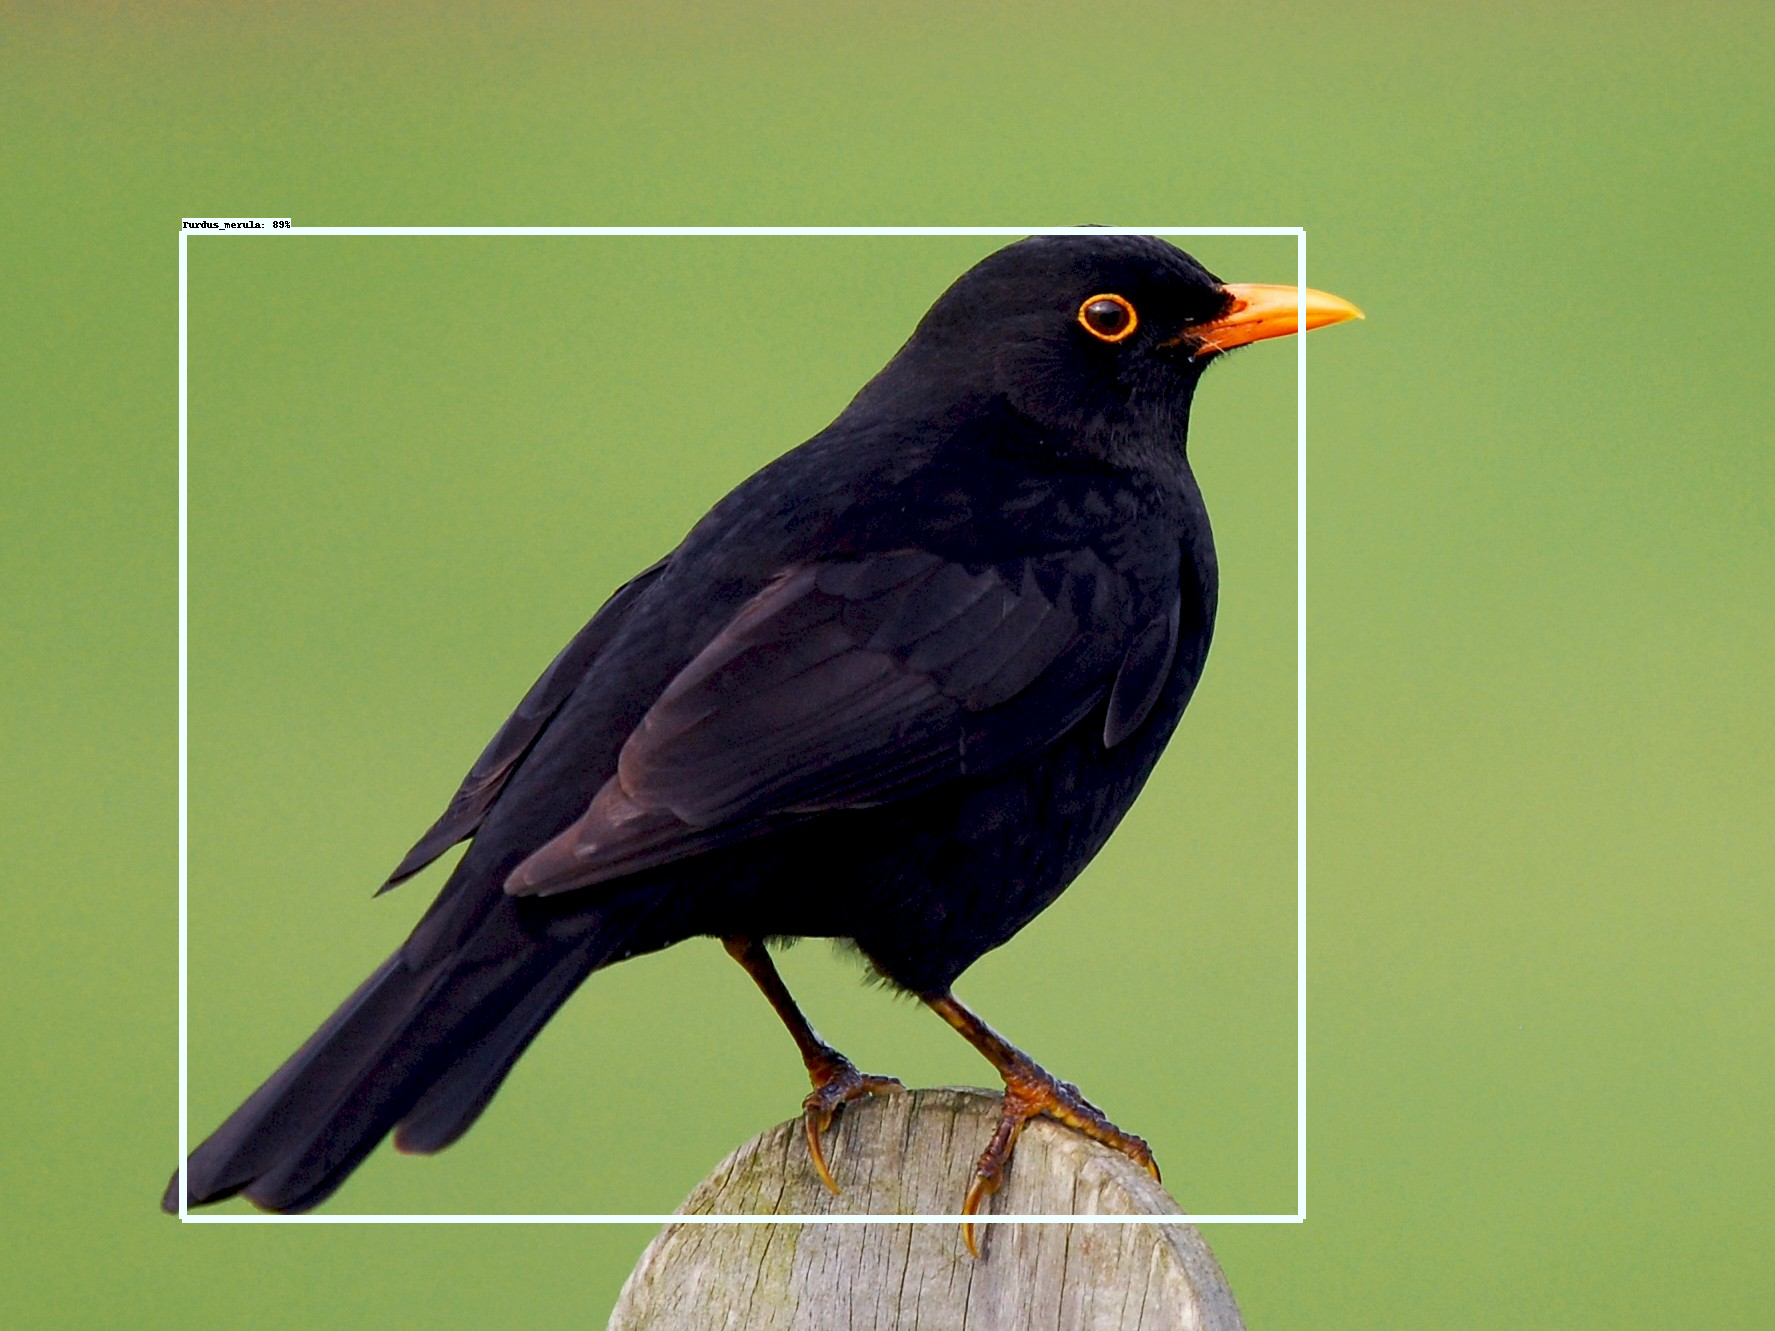

2023-01-09 15:51:01.207705: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 963379200 exceeds 10% of free system memory.


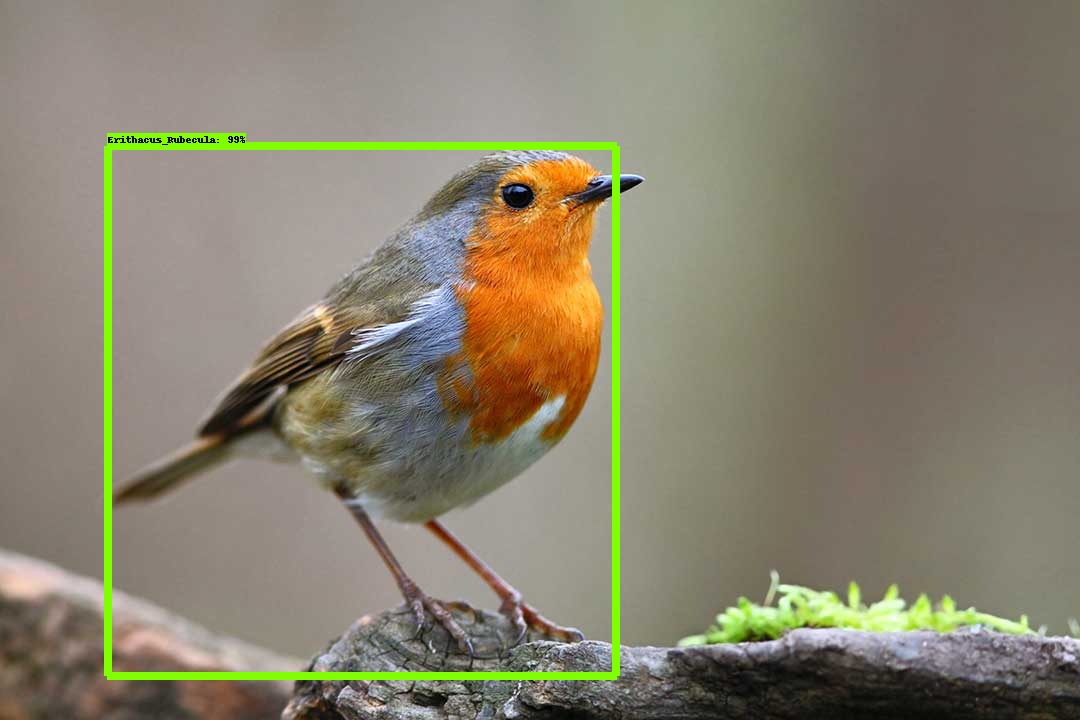

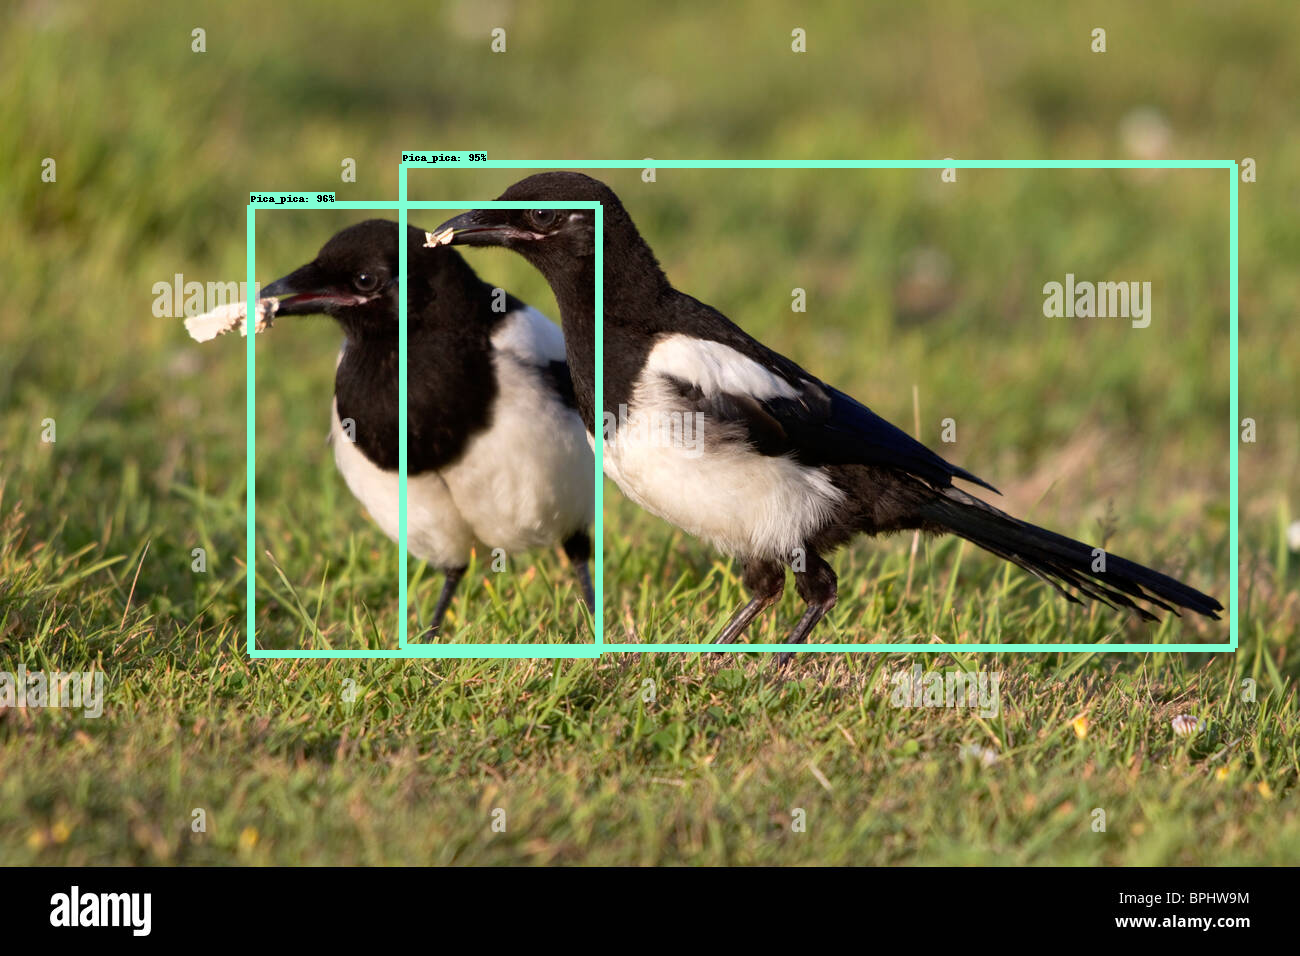

In [39]:
# Making inferences on images stored in Birds_test folder
# Birds_test folder contains unseen images downloaded from the Internet 
for image_path in glob.glob(os.path.join(current_dir,'Birds_test/*.jpg')):
  image_np = load_image_into_numpy_array(image_path)
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)
  # Display inferences with bounding boxes
  display(Image.fromarray(image_np))

## Discussion

- In this project, we used different approaches to improve the performance of a baseline ```faster_rcnn_resnet101_v1_640x640_coco17_tpu-8``` on a custom database (BBC AutmunWatch) for bird detection.

- The EDA results indicate that the BBC AutumnWatch is a high quality, balanced, but centrally biased dataset (annotations) with no corrupted images.

- the pre-processing and Hyperparameter tuning steps are crutial in sofar as they made the model more accurate after training.

- Although computer resources and the amount of training samples are limited, we can always reuse the saved model weights on another (usually larger) dataset to improve its performance thanks to transfer learning.

- Our mean average Precision scores at 0.5 and 0.75 levels of IoU were ```mAP@.5 = 0.85``` and ```mAP@.75 = 0.66``` respectively, our average Recall (sensitivity) score was ```AR = 0.62``` which are acceptable compared to the model deployed on Roboflow Cloud with an optimized training config. 

- The classes with the highest average precision (```Pica_pica```,  ```Periparus_ater``` and ```Turdus_merula```) are likely being accurately detected and classified by the model. The classes with lower average precision (```Erithacus_Rubecula```) may not be being detected or classified as accurately by the model.

- From the inference tests (see above) and side by side evaluation (TensorBoard) we can see that the positioning of the bounding boxes reflects the mAP scores (@0.5 and @0.75 IoU level) and AR as being very close to the ground truth.


Comparison results of different extentions of the basic ```faster_rcnn_resnet101``` indicate the pre-trained model improved in mAP and AR using transfer learning on a custum database which makes it an interesting candidate for further investigations.

<p style="color:blue">I tried with SSD Resnet101 many times but the model is still not achieving satisfactory performance.</p>

#### Further improvements

It is possible to improve the performance of our model. Here are some suggestions:


- **Collect more data**: One of the most effective ways to improve a machine learning model is to train it on more data. This can be especially helpful for object detection models, which often benefit from large amounts of diverse training data.

- **Experiment with different model architectures** (See the other models): We can also try using different model architectures or hyperparameter settings to see if they yield better results on our small dataset.

- Investigate why ```Erithacus_Rubecula``` has a lower average precision and consider ways to improve the model's performance for that class.

**Hyperparameter tuning** can impact the accuracy and performance of the model in many ways:

- **Use a larger batch size**: Training with a larger batch size can sometimes lead to improved model performance. This is because larger batch sizes can allow the model to make better use of GPU parallelism and can also help with optimization.

- **Use a smaller learning rate**: we can try using a smaller learning rate to allow the model to make more incremental updates to the model weights. This can help the model learn more gradually, which can improve its generalization performance.

- **Use a different optimizer**: we can try using a different optimizer, such as ```Adam``` or ```RMSprop```, to see if it leads to improved performance. Different optimizers can have different properties and may be more or less effective depending on the characteristics of your dataset and model.





## Proposal for production deployment 

The following is a high-level proposal for deploying our object detection model using TensorFlow 2 and MLOPS best practices:

The training data and the model's code can be stored in a version control system such as Git, in order to track the changes and enable collaboration.

### Model serving:

The trained model can be served using TensorFlow Serving, which is a flexible, high-performance serving system for machine learning models.

TensorFlow Serving can be deployed on a cloud provider, on-premises, or in a hybrid environment, using a container orchestration platform such as Kubernetes. This will allow the model to be easily scaled and managed.

### Model deployment:

The model can be deployed using a continuous integration and deployment (CI/CD) pipeline, which will automatically build, test, and deploy the model to the serving environment.

The CI/CD pipeline can be implemented using tools such as Jenkins or GitLab CI, which will trigger the deployment when a new version of the model is committed to the version control system.

### Monitoring and logging:

It is important to monitor the performance and availability of the model in production, in order to ensure that it is able to meet the required SLAs. This can be done using tools such as Prometheus and Grafana for monitoring, and Elasticsearch, Logstash, and Kibana (ELK) for logging.

### Model management:

The model's metadata, such as the version, performance metrics, and deployment history, can be stored in a model registry, such as AWS Model Registry or GCP Model Registry. This will allow the model to be easily tracked and managed.

The model can be promoted through different environments (e.g. staging, production) using a model rollout strategy, such as blue-green or canary deployment, in order to minimize the risk of model degradation. Blue-green deployment involves maintaining two identical production environments, and routing traffic between them to minimize downtime and risk during deployments, whereas Canary deployment involves gradually rolling out the new version of the system to a small subset of users, and gradually increasing the number over time, in order to minimize the risk and impact of deployments. 





